# Carico le librerie necessarie

In [1310]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# carico i dati

In [1248]:
x_train = pd.read_csv('kaggle_data/train.csv')
x_test = pd.read_csv('kaggle_data/test.csv')

In [1249]:
x_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,.

* la variabile Id viene rimossa dal test set perchè non utile ma viene conservata perchè serve per la submission finale

In [1250]:
y_train = np.log(x_train['SalePrice'])
Id_test = x_test['Id'] # questo serve per la submission finale
x_train = x_train.drop('Id', axis= 1)
x_test = x_test.drop('Id', axis = 1)

In [1251]:
nums = x_train.select_dtypes(exclude='object')
nums_cols = nums.columns.to_list() 

In [1252]:
cat_cols = x_train.select_dtypes(include='object').columns.to_list()

In [1253]:
corr = nums.corr()

In [1254]:
import seaborn as sns
corr['SalePrice'].sort_values(ascending=False) # guardo quali variabili sono maggiormente correlate con la target variable (anche se non considera relazioni non lineari tra variabili)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [1255]:
high_corrs = []
for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i, j]) > 0.7:
                high_corrs.append((
                    corr.index[i],
                    corr.columns[j],
                    corr.iloc[i, j]
                ))

In [1256]:
high_corrs

[('1stFlrSF', 'TotalBsmtSF', np.float64(0.8195299750050339)),
 ('TotRmsAbvGrd', 'GrLivArea', np.float64(0.8254893743088425)),
 ('GarageYrBlt', 'YearBuilt', np.float64(0.8256674841743408)),
 ('GarageArea', 'GarageCars', np.float64(0.882475414281462)),
 ('SalePrice', 'OverallQual', np.float64(0.7909816005838053)),
 ('SalePrice', 'GrLivArea', np.float64(0.7086244776126515))]

* Alta correlazione tra GarageArea e GarageCars perchè sono la stessa cosa praticamente, è come avere temperatura in celsius e Ferenheit
Per questo dopo una delle due viene rimossa dal df


In [1257]:
def removeFeature(features: list, *dfs):
    for df in dfs:
        df.drop(features, axis=1, inplace=True)

In [1258]:
removeFeature(['GarageCars','LotArea'], x_train, x_test)

## Rimozione delle Outliers
* trovo outliers guardando a plot di ogni variabile numerica rispetto alla target variable
* per ora l'obiettivo è rendere i dati puliti, probabilmente la rimozione delle outliers non è necessaria per ensamble methods (e.g. RF è robusta contro le outliers)

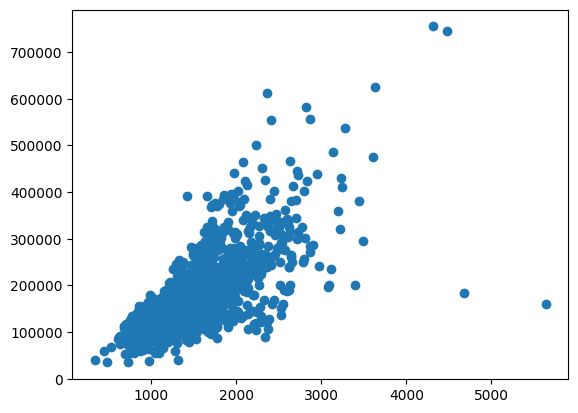

In [1259]:
plt.scatter(data=x_train, x='GrLivArea', y='SalePrice')

In [1260]:
ixs = x_train.index[x_train['GrLivArea'] > 4000].tolist()

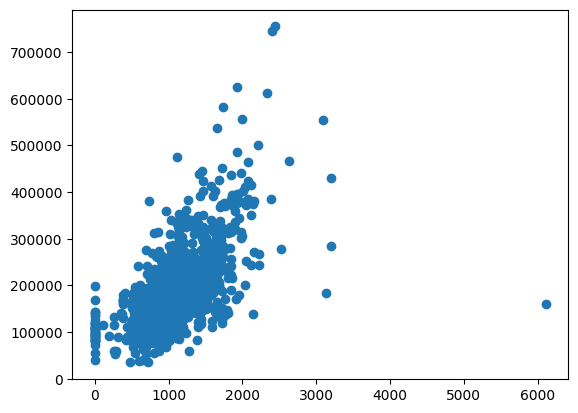

In [1261]:
plt.scatter(data=x_train, x='TotalBsmtSF', y='SalePrice')

In [1262]:
ixs += x_train.index[x_train['TotalBsmtSF'] > 4000].to_list()

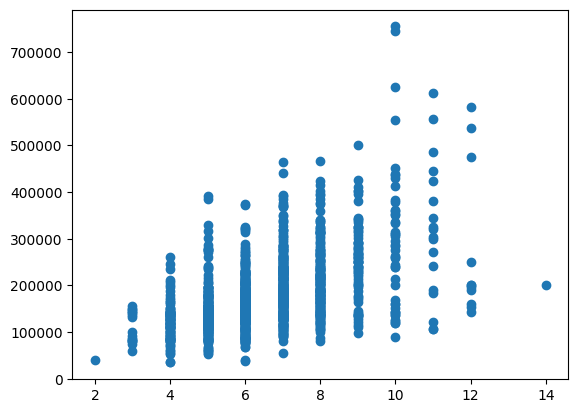

In [1263]:
plt.scatter(data=x_train, x='TotRmsAbvGrd', y='SalePrice')

In [1264]:
ixs += x_train.index[x_train['1stFlrSF'] > 4000].to_list()

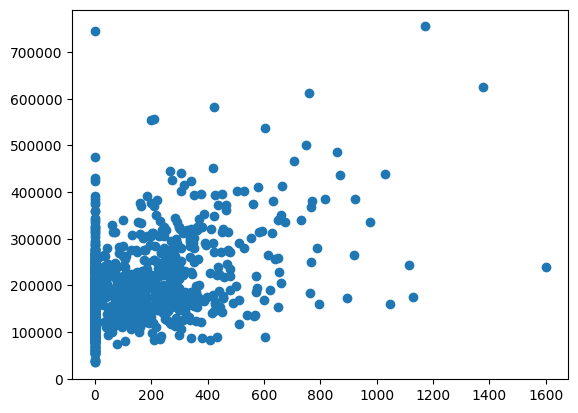

In [1265]:
plt.scatter(data=x_train, x='MasVnrArea', y='SalePrice')

In [1266]:
ixs += x_train.index[x_train['MasVnrArea'] > 1200].to_list()

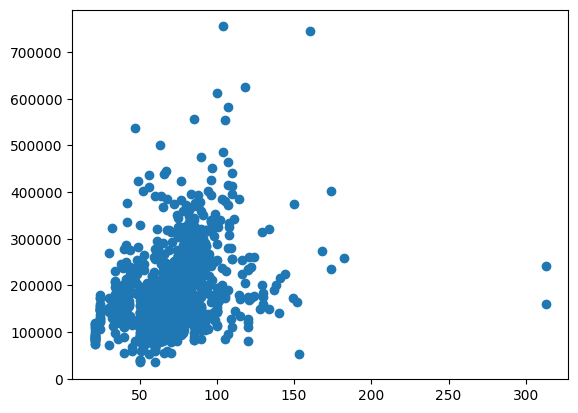

In [1267]:
plt.scatter(data=x_train, x='LotFrontage', y='SalePrice')

In [1268]:
ixs += x_train.index[x_train['BsmtFinSF1'] > 4000].to_list()

In [1269]:
ixs += x_train.index[x_train['LotFrontage'] > 250].to_list()

In [1270]:
x_test = x_test.drop(list(set(ixs)))

Fino a qui ho droppato tutte le features GarageCars, Id e le righe delle outliers

## Feature eng

In [1271]:
x_train['houseAge'] = x_train['YrSold'] - x_train['YearBuilt']
x_test['houseAge'] = x_test['YrSold'] - x_test['YearBuilt']

In [1272]:
x_test['houseRemodAge'] = x_test['YrSold'] - x_test['YearRemodAdd']
x_train['houseRemodAge'] = x_train['YrSold'] - x_train['YearRemodAdd']

In [1273]:
x_test['totalSf'] = x_test['1stFlrSF'] + x_test['2ndFlrSF'] + x_test['BsmtFinSF1'] + x_test['BsmtFinSF2']
x_train['totalSf'] = x_train['1stFlrSF'] + x_train['2ndFlrSF'] + x_train['BsmtFinSF1'] + x_train['BsmtFinSF2']

In [1274]:
x_train['totalArea'] = x_train['GrLivArea'] + x_train['TotalBsmtSF']
x_test['totalArea'] = x_test['GrLivArea'] + x_test['TotalBsmtSF']

In [1275]:
x_train['totalbaths'] = x_train['BsmtFullBath'] + x_train['FullBath'] + 0.5 * (x_train['BsmtHalfBath'] + x_train['HalfBath']) 
x_test['totalbaths'] = x_test['BsmtFullBath'] + x_test['FullBath'] + 0.5 * (x_test['BsmtHalfBath'] + x_test['HalfBath'])

In [1276]:
x_test['totalporchsf'] = x_test['OpenPorchSF'] + x_test['3SsnPorch'] + x_test['EnclosedPorch'] + x_test['ScreenPorch'] + x_test['WoodDeckSF']
x_train['totalporchsf'] = x_train['OpenPorchSF'] + x_train['3SsnPorch'] + x_train['EnclosedPorch'] + x_train['ScreenPorch'] + x_train['WoodDeckSF']

In [1277]:
features_to_remove = ['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF']
removeFeature(features_to_remove, x_train, x_test)

In [1278]:
removeFeature('SalePrice', x_train)

* Fatto feature engineering e rimosso variabili che ora sono incluse in quelle aggiunte
* Ora si devono trattare i Nans

In [1279]:
x_train.isnull().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageFinish      81
GarageQual        81
GarageYrBlt       81
dtype: int64

In [1280]:
removeFeature(['PoolQC','MiscFeature','Alley','Fence','MasVnrType'], x_train, x_test)

Rimosse le colonne che hanno troppi Nans

Fino a qui ho modificato sia training che test set. 
1. Ho rimosso oultiers dal training
2. Ho fatto feature eng (e ho modificato anche il test set)
3. ho eliminato le features con troppi nan e quelle che non erano necessarie (come GarageCars)

In [1281]:
cat_cols = x_train.select_dtypes(include='object').columns.to_list()

In [1282]:
x_train[cat_cols].loc[:,x_train[cat_cols].isnull().sum() > 0].isnull().sum()

BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [1283]:
# in queste categorie il Nan dovrebbe essere una nuova classe, quindi viene trasformato in No
x_train.fillna({
    'FireplaceQu':'No',
    'BsmtQual': 'No',
    'BsmtCond': 'No',
    'BsmtExposure' :'No',
    'BsmtFinType1' : 'No',
    'BsmtFinType2': 'No',
    'GarageType':'No',
    'GarageFinish':'No',
    'GarageQual':'No',
    'GarageCond':'No', 
    }, inplace=True)

In [1284]:
imputer_cat = SimpleImputer(strategy='most_frequent') 
x_train[cat_cols] = imputer_cat.fit_transform(x_train[cat_cols])
# per le altre colonne categoriche i nans sono sostituiti dalla ricorrenza + comune

In [1285]:
nums_cols = x_train.select_dtypes(exclude='object').columns.to_list()

In [1286]:
imputer_num = SimpleImputer(strategy='median')
x_train[nums_cols] = imputer_num.fit_transform(x_train[nums_cols])
# colonne numeriche i nans sono sostituiti dalla mediana

In [1287]:
enc = OneHotEncoder(sparse_output=False)
cat_enc = enc.fit_transform(x_train[cat_cols])
x_train = x_train.drop(cat_cols, axis=1)
x_train = np.c_[x_train, cat_enc]

In [1288]:
x_train

array([[60., 65.,  7., ...,  0.,  1.,  0.],
       [20., 80.,  6., ...,  0.,  1.,  0.],
       [60., 68.,  7., ...,  0.,  1.,  0.],
       ...,
       [70., 66.,  7., ...,  0.,  1.,  0.],
       [20., 68.,  5., ...,  0.,  1.,  0.],
       [20., 75.,  5., ...,  0.,  1.,  0.]])

In [1289]:
x_train.shape

(1460, 266)

In [1290]:
fts = cat_cols + nums_cols

**Ora non ci sono Nans.**
**Le colonne sulle quali viene allenato il modello sono 60 e sono quelle presenti in fts**

A seguire vengono create delle classi che servono a modificare poi i dati di input, così che subiscano le trasformazioni necessarie ad essere processati:
1. arrivano i dati
2. vengono divisi in numerici e categorici
3. nei numerici viene fatto feature engineering, i Nans sono sostituiti con la mediana, vengono standardizzati
4. Nei categorici i nans, tranne che per le classi dove hanno importanza, sono sostituiti con most frequent poi viene fatto 1HE

In [1291]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombineAttributes(BaseEstimator, TransformerMixin): # per fare feature eng su un df nuovo
    def __init__(self):
        pass
    def fit (self, X, y=None):
        return self
    def transform(self, X, y=None):
        houseAge = X['YrSold'] - X['YearBuilt']
        houseRemodAge = X['YrSold'] - X['YearRemodAdd']
        totalSf = X['1stFlrSF'] + X['2ndFlrSF'] + X['BsmtFinSF1'] + X['BsmtFinSF2']
        totalArea = X['GrLivArea'] + X['TotalBsmtSF']
        totalbaths = X['BsmtFullBath'] + X['FullBath'] + 0.5 * (X['BsmtHalfBath'] + X['HalfBath'])
        totalporchsf = X['OpenPorchSF'] + X['3SsnPorch'] + X['EnclosedPorch'] + X['ScreenPorch'] + X['WoodDeckSF']

        X = X.drop(['YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF','BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch','WoodDeckSF'], axis=1)
        X = np.c_[X, houseAge, houseRemodAge, totalSf, totalArea, totalbaths, totalporchsf]
        return X

In [1292]:
unimportantFeatures = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','GarageCars']
class DropUnimportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit (self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.drop(unimportantFeatures, axis=1)
        return X

In [1293]:
class ImputerImportantNans(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X.fillna({
        'FireplaceQu':'No',
        'BsmtQual': 'No',
        'BsmtCond': 'No',
        'BsmtExposure' :'No',
        'BsmtFinType1' : 'No',
        'BsmtFinType2': 'No',
        'GarageType':'No',
        'GarageFinish':'No',
        'GarageQual':'No',
        'GarageCond':'No', 
        }, inplace=True)
        return X

In [1294]:
all_pipeline = Pipeline([
    ('dropUnimportant', DropUnimportantFeatures())
])

In [1295]:
num_pipline = Pipeline([
    ('comb_attr', CombineAttributes()),
    ('impute_med', SimpleImputer(strategy='median')),
    ('std_scale', StandardScaler())
])

In [1296]:
cat_pipline = Pipeline([
    ('importantNans', ImputerImportantNans()),
    ('imp_mf', SimpleImputer(strategy='most_frequent')),
    ('1he', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [1297]:
from sklearn.compose import ColumnTransformer
full_pip = ColumnTransformer([
    ('cat', cat_pipline, cat_cols),
    ('num', num_pipline, nums_cols)
])  ## questo transformer fa tutto tranne rimuovere le righe con le outliers e togliere le colonne con troppi nan, questo possiamo farlo manualmente

Per modificare i dati ricevuti come input, abbiamo:
1. cat_imputer: per mettere il + comune alle categorie non numeriche
2. imputer: per mettere la mediana a quelle numeriche
3. combineattributes: per combinare gli attributi 

Devo creare due pipelines:
1. attributi numerici:
    - feature eng
    - replace with median
    - scaler
2. attributi categorici:
    - replace con 'No' le categorie che hanno senso
    - replace with most frequent
    - one_hot_enc

Provo la pipeline su una copia del df originale

In [1298]:
xs = pd.read_csv('kaggle_data/train.csv')
xs.shape

(1460, 81)

In [1299]:
xs = xs.drop(ixs)
xs.shape

(1453, 81)

In [1300]:
xs = xs.drop(['SalePrice'] + unimportantFeatures, axis=1)

In [1301]:
nums_cols = xs.select_dtypes(exclude='object').columns.to_list()
cat_cols = xs.select_dtypes(include='object').columns.to_list()
fts = xs.columns.to_list()

In [1302]:
from sklearn.compose import ColumnTransformer
full_pip = ColumnTransformer([
    ('cat', cat_pipline, cat_cols),
    ('num', num_pipline, nums_cols)
])  ## questo transformer fa tutto tranne rimuovere le righe con le outliers e togliere le colonne con troppi nan, questo possiamo farlo manualmente

In [1303]:
xs = full_pip.fit_transform(xs)
xs.shape

(1453, 267)

In [1307]:
y_train = y_train.drop(ixs)

Ora i dati sono pronti per andare in un modello

In [1308]:
xgb_reg = XGBRegressor()
xgb_reg.fit(xs,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [1309]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb_reg, xs, y_train, scoring='neg_root_mean_squared_error', cv=5)

print('Scores:', -scores)
print('Mean RMSE:', -scores.mean())

Scores: [0.1246335  0.1365329  0.13765799 0.12649292 0.12838491]
Mean RMSE: 0.1307404454889716


In [1332]:
rf_reg = RandomForestRegressor(n_jobs=-1, n_estimators=1000)
rf_reg.fit(xs, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1)

In [1333]:
scores = cross_val_score(rf_reg, xs, y_train, scoring='neg_root_mean_squared_error', cv=5)

print('Scores:', -scores)
print('Mean RMSE:', -scores.mean())

Scores: [0.13008133 0.13352857 0.13666034 0.12997493 0.13662535]
Mean RMSE: 0.13337410659956045


In [1334]:
importances = rf_reg.feature_importances_
median = np.median(importances)
ixsImportantFts = np.where(importances > median)[0]
xsImpFts = xs[:, ixsImportantFts]

In [1346]:
rf_reg_importantFeatures = RandomForestRegressor(n_jobs=-1, n_estimators=10000)
rf_reg_importantFeatures.fit(xsImpFts, y_train)

RandomForestRegressor(n_estimators=10000, n_jobs=-1)

In [1336]:
scores = cross_val_score(rf_reg_importantFeatures, xsImpFts, y_train, scoring='neg_root_mean_squared_error', cv=5)

print('Scores:', -scores)
print('Mean RMSE:', -scores.mean())

Scores: [0.12996609 0.13329847 0.13647234 0.12959694 0.13648562]
Mean RMSE: 0.1331638918412


Qui ho provato a fare Gridsearch e randomSearch per trovare parametri migliori da usare. Unica scoperta è che usare n_estimators maggiore porta a migliori risultati

In [463]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'learning_rate': [0.01, 0.1, 0.5], 'n_estimators': [3, 10, 30]},
 {'max_features': [2, 4, 6, 8],'bootstrap': [False]}
 ]
grid_search = GridSearchCV(xgb_reg, param_grid, cv=5, scoring='neg_root_mean_squared_error',return_train_score=True)
grid_search.fit(xs, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid=[{'learning_rate': [0.01, 0.1, 0.5],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 4, 6, 8]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [468]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = [
    {'eta': [0.01, 0.1, 0.2], 'gamma': [0,1,10]},
    {'max_depth': [3,6,10], 'n_estimators': [10, 100, 1000]}
]

grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(xs, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid=[{'eta': [0.01, 0.1, 0.2], 'gamma': [0, 1, 10]},
                         {'max_depth': [3, 6, 10],
                          'n_estimators': [10, 100, 1000]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [467]:
randSearch

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001D9CC2F3D90>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D9CCAEB580>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D9CCAEA530>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001D9CCAE9090>})

Qui carico i risultati

In [1329]:
xs_t = pd.read_csv('kaggle_data/test.csv')

In [1330]:
xs_t = xs_t.drop(unimportantFeatures, axis=1)

In [ ]:
# dovrei riuscire a prendere dei dati, fare full_pip.transform e ottenere un df processabile

In [1331]:
xs_t = full_pip.transform(xs_t)

In [1339]:
ys_xgb = xgb_reg.predict(xs_t)
ys_rf = rf_reg.predict(xs_t)
ys_rf_imp = rf_reg_importantFeatures.predict(xs_t[:, ixsImportantFts])

In [1340]:
ys_xgb = np.exp(ys_xgb)
ys_rf = np.exp(ys_rf)
ys_rf_imp = np.exp(ys_rf_imp)

In [1341]:
sub_xgb_2 = pd.DataFrame({
    'Id' : Id_test,
    'SalePrice' : ys_xgb
})

In [1342]:
sub_rf_2 = pd.DataFrame({
    'Id' : Id_test,
    'SalePrice' : ys_rf
})

In [1347]:
sub_rf_imp = pd.DataFrame({
    'Id' : Id_test,
    'SalePrice' : ys_rf_imp
})

In [1348]:
sub_xgb_2.to_csv('predictions/sub_xgb2.csv', index=False)
sub_rf_2.to_csv('predictions/sub_rf2.csv', index=False)
sub_rf_imp.to_csv('predictions/sub_rf_imp2.csv', index=False)